In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torchinfo
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

#for data preprocessing
from sklearn.decomposition import PCA

from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, mean_squared_error, roc_curve,
                            auc, matthews_corrcoef,r2_score,classification_report,precision_recall_curve)
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input
#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

#filter warnings
import warnings
warnings.filterwarnings("ignore")

import os
#print(os.listdir(r'C:\Users\AMJAD\AD\Datasets')

# Any results you write to the current directory are saved as output.

### Exploratory Data Analysis

In [2]:
df = pd.read_csv(r'C:\Users\AMJAD\AD\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\Datasets/creditcard_2023.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


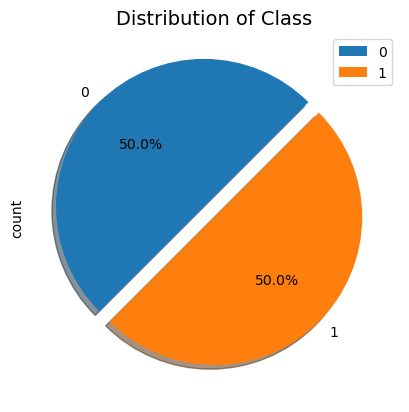

In [3]:
df['Class'].value_counts().plot.pie(explode=[0.1,0],autopct='%3.1f%%'
                                     ,shadow=True, legend= True,startangle =45)
plt.title('Distribution of Class',size=14)
plt.show()

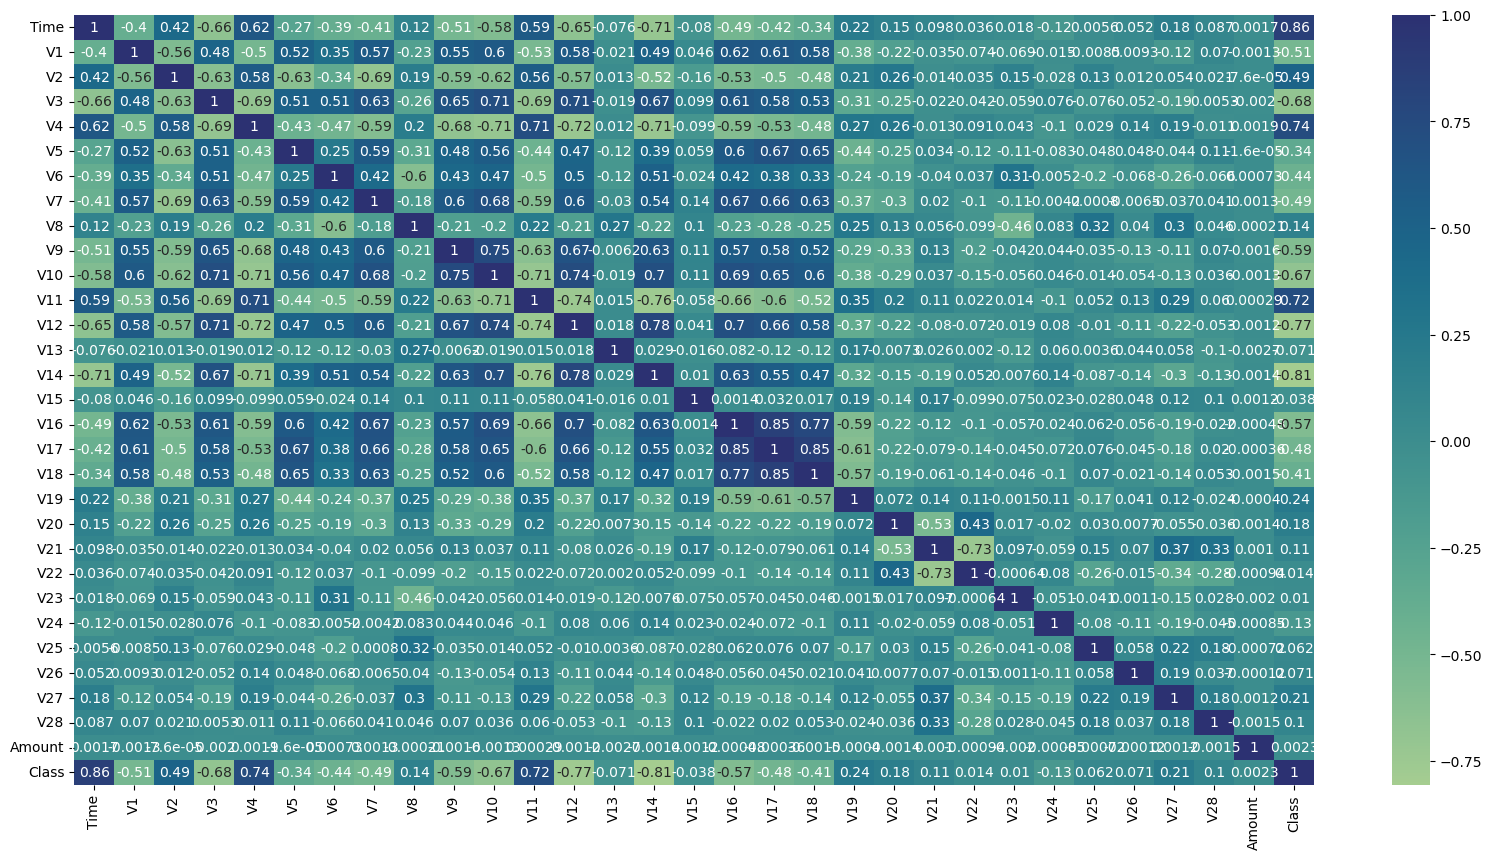

In [4]:
paper = plt.figure(figsize=[20,10])
sns.heatmap(df.corr(),cmap='crest',annot=True)
plt.show()

<Axes: >

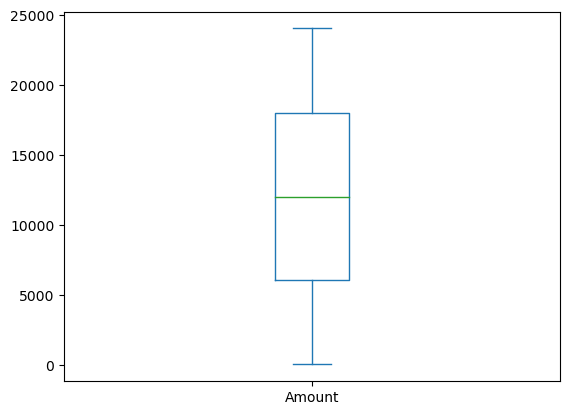

In [5]:
df['Amount'].plot.box()

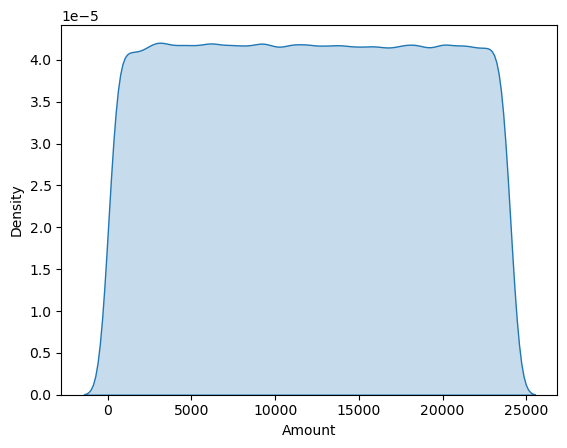

In [6]:
sns.kdeplot(data=df['Amount'], shade=True)
plt.show()

Lets visualize how many fraud cases we have in this dataset

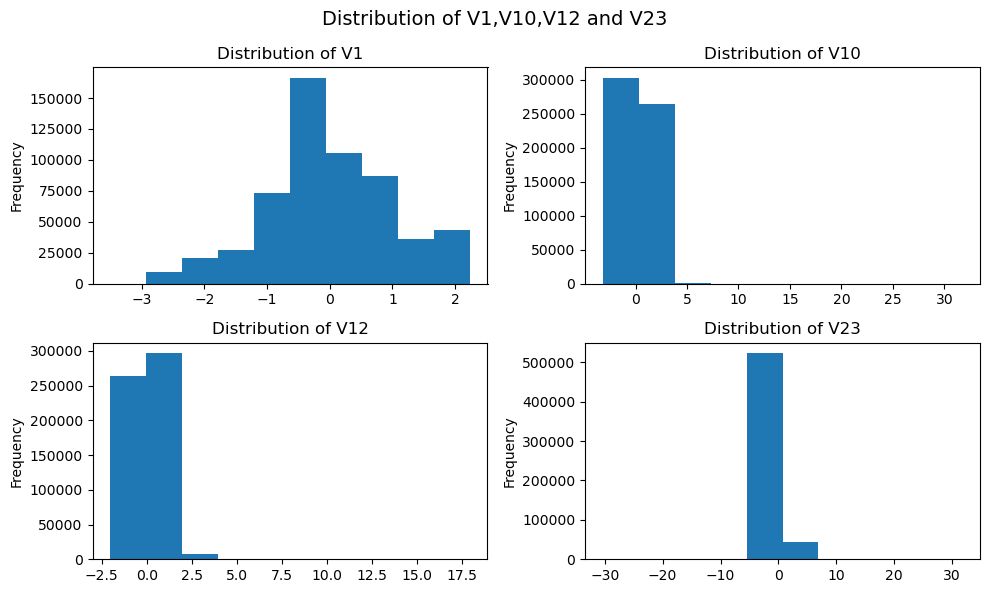

In [7]:
# Lets plot a histogram
paper, axes = plt.subplots(2, 2, figsize=(10, 6))
df['V1'].plot(kind='hist', ax=axes[0,0], title='Distribution of V1')
df['V10'].plot(kind='hist', ax=axes[0,1], title='Distribution of V10')
df['V12'].plot(kind='hist', ax=axes[1,0], title='Distribution of V12')
df['V23'].plot(kind='hist', ax=axes[1,1], title='Distribution of V23')
plt.suptitle('Distribution of V1,V10,V12 and V23',size=14)
plt.tight_layout()
plt.show()

We have 50% fraud cases in the dataset which are anomalies.

Only `Time` and `Amount` have not been transformed with PCA. Time contains the seconds elapsed between each transaction and the first transaction in the dataset. Lets transofrm this feature into hours to get a better understanding.

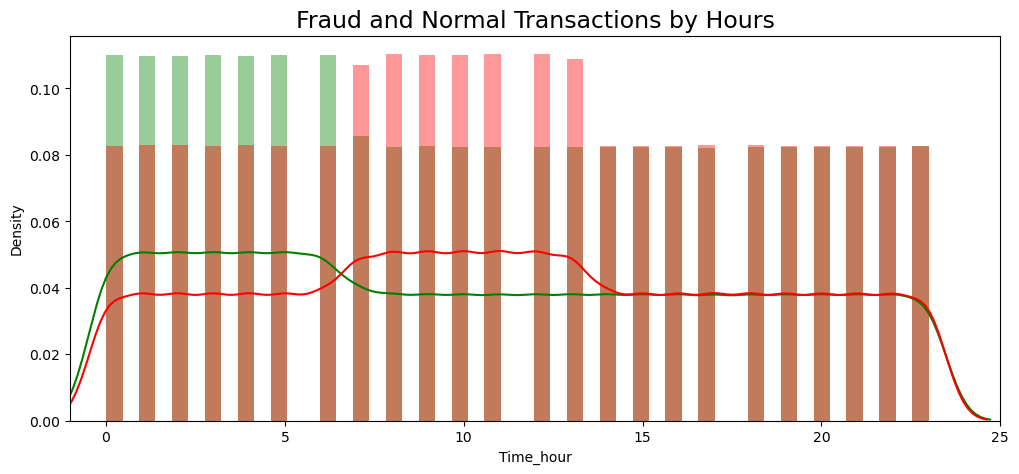

In [8]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

Seems like hour of day have some impact on number or fraud cases. Lets move to transform the remaining features.

### Feature Transformation

Lets transform the remaining features using PCA.

In [9]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

#df.drop(['Time','Time_hour', 'Amount'], axis=1, inplace=True)

df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_hour', 'V29', 'V30'],
      dtype='object')

Now lets have a view at distribution of features

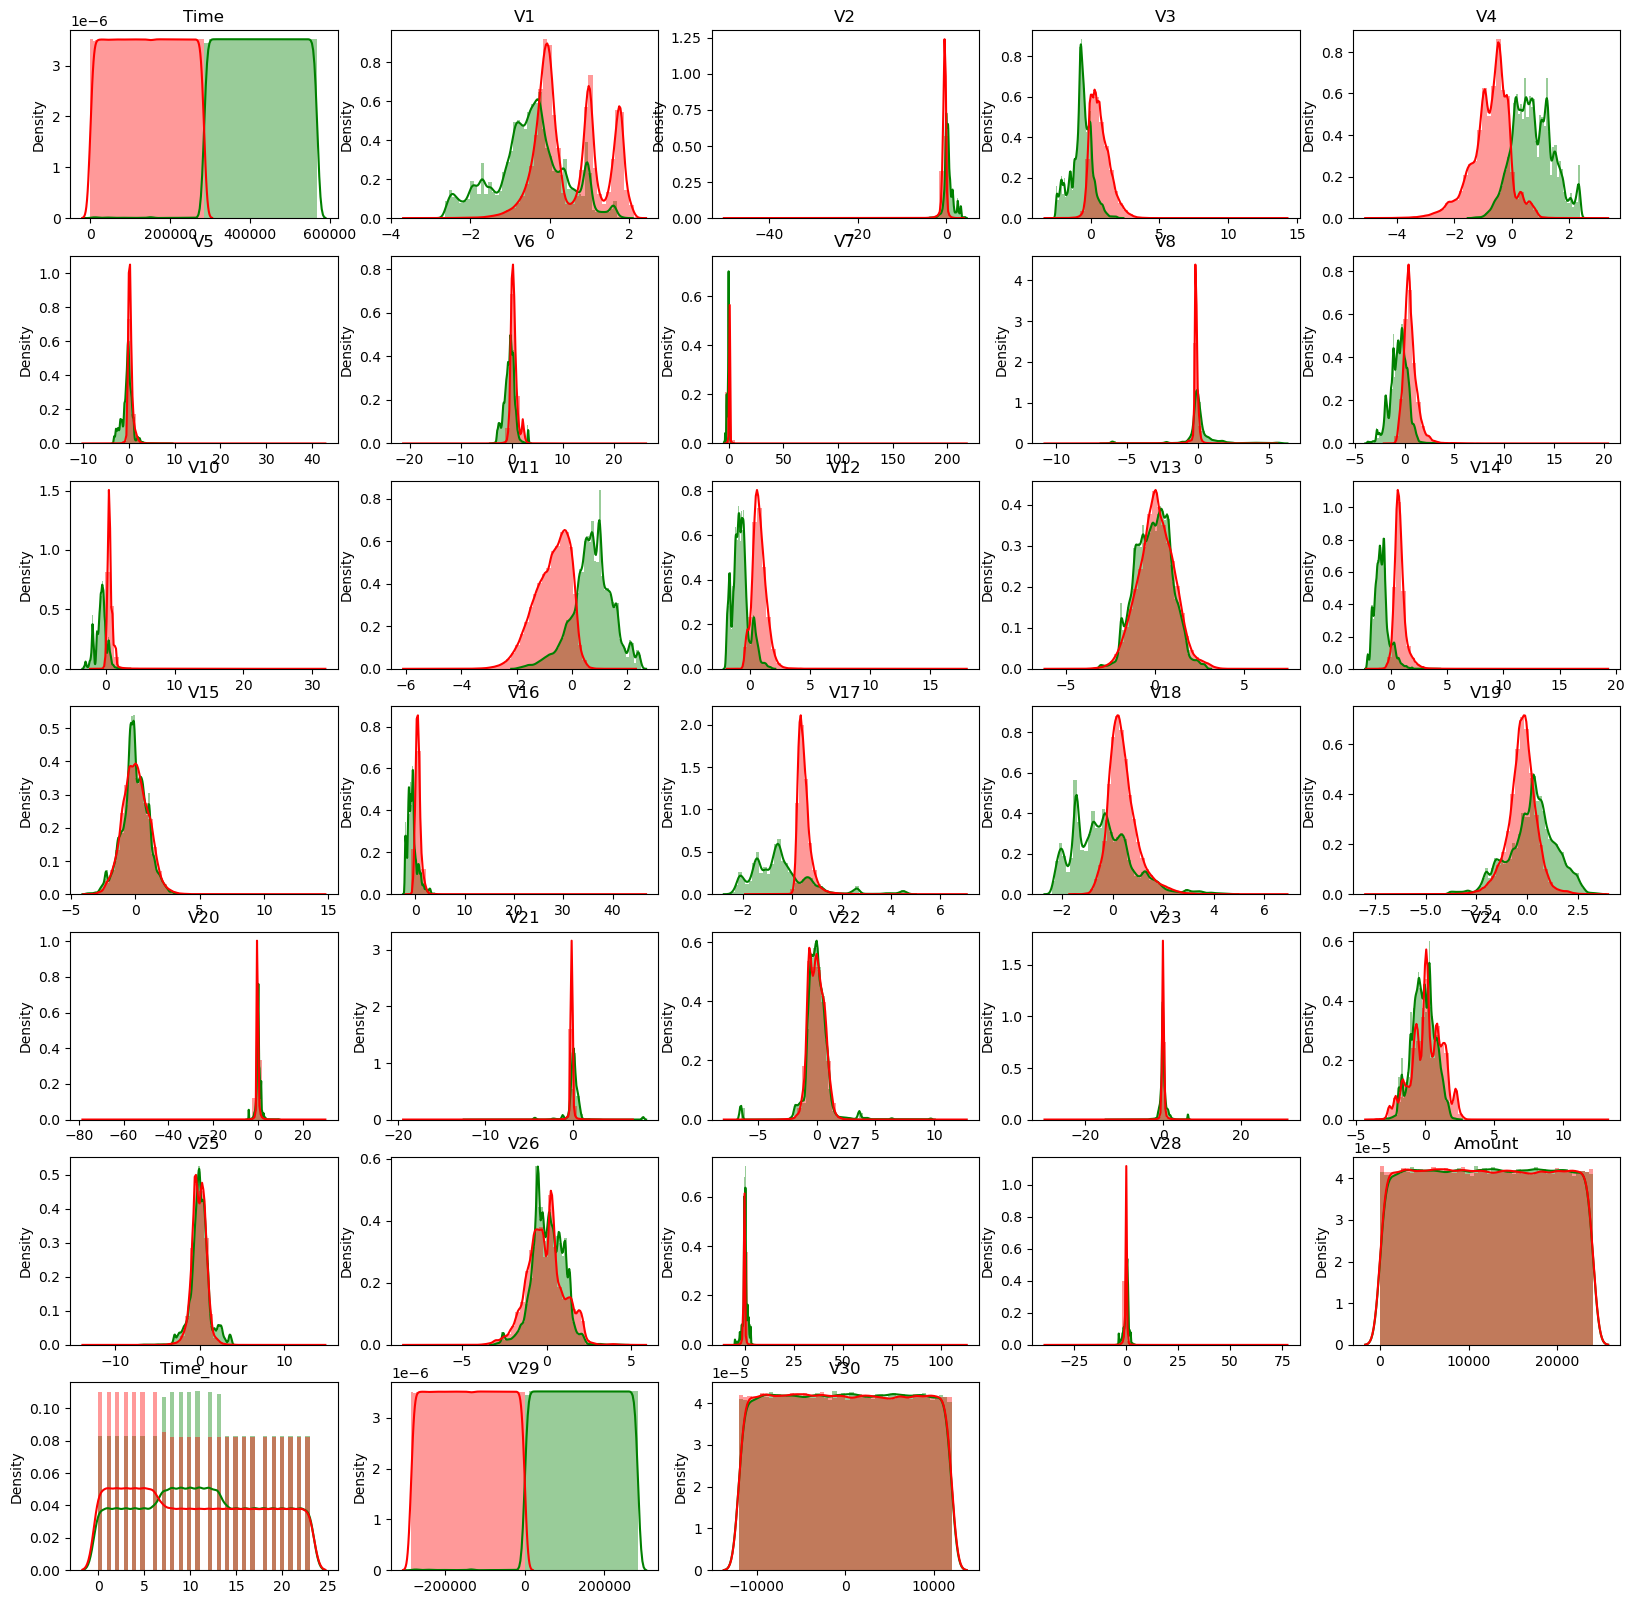

In [10]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(7, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins = 50, color='g')
    sns.distplot(df[df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

## Feature Selection using Statistical  Method


In [11]:
df.groupby('Class').corr()

Time        V1        V2        V3        V4        V5  \
Class                                                                         
0     Time       1.000000  0.199042 -0.001161 -0.423868 -0.106979  0.143039   
      V1         0.199042  1.000000 -0.055030 -0.396697  0.124702 -0.149860   
      V2        -0.001161 -0.055030  1.000000  0.058519 -0.018778 -0.208666   
      V3        -0.423868 -0.396697  0.058519  1.000000  0.058980 -0.119305   
      V4        -0.106979  0.124702 -0.018778  0.058980  1.000000  0.022682   
...                   ...       ...       ...       ...       ...       ...   
1     V28        0.001862  0.242537 -0.044293  0.176614 -0.215672  0.224000   
      Amount    -0.000275  0.002539 -0.003664  0.001391 -0.000339  0.001804   
      Time_hour -0.098776  0.000989 -0.000356  0.001427 -0.001271  0.001423   
      V29        1.000000  0.001413 -0.002547  0.002535 -0.003316  0.002115   
      V30       -0.001142  0.002538 -0.003662  0.001388 -0.000336  0.001802   

                       V6        V7        V8        V9  ...       V23  \
Class                                                    ...             
0     Time      -0.070256  0.057100 -0.037491 -0.015548  ...  0.051756   
      V1        -0.041742 -0.165866 -0.050292  0.060111  ...  0.010991   
      V2         0.074779 -0.120781  0.036470 -0.016143  ... -0.095094   
      V3         0.044699 -0.087170  0.023190 -0.010993  ... -0.052026   
      V4        -0.023988  0.046073 -0.011994  0.009895  ...  0.023376   
...                   ...       ...       ...       ...  ...       ...   
1     V28       -0.038930  0.179648  0.039279  0.253637  ...  0.038307   
      Amount     0.001542  0.002174 -0.000686  0.001075  ... -0.001845   
      Time_hour -0.000786  0.001304  0.000914  0.002221  ... -0.000456   
      V29        0.003312  0.002131 -0.003525  0.002261  ...  0.001841   
      V30        0.001539  0.002172 -0.000683  0.001073  ... -0.001846   

                      V24       V25       V26       V27       V28    Amount  \
Class                                                                         
0     Time      -0.013129 -0.224554 -0.035146 -0.000387 -0.009595 -0.000696   
      V1         0.001640  0.057628  0.001264 -0.083598 -0.015976 -0.003098   
      V2        -0.008372 -0.013842  0.013844 -0.097460 -0.010889  0.001901   
      V3         0.012665  0.017296  0.006925 -0.022677 -0.010645 -0.002800   
      V4        -0.014467 -0.007107  0.028778 -0.006999 -0.002738  0.000924   
...                   ...       ...       ...       ...       ...       ...   
1     V28       -0.063270  0.257053  0.053319  0.233159  1.000000 -0.001100   
      Amount    -0.001954 -0.002096  0.001644  0.000646 -0.001100  1.000000   
      Time_hour -0.001718  0.001902 -0.000540 -0.000640  0.000923 -0.002098   
      V29       -0.002494 -0.002121  0.001090 -0.002202  0.001862 -0.000269   
      V30       -0.001952 -0.002095  0.001643  0.000648 -0.001102  1.000000   

                 Time_hour       V29       V30  
Class                                           
0     Time        0.103016  1.000000 -0.001553  
      V1          0.028491  0.199042 -0.003268  
      V2         -0.013130 -0.001161  0.001902  
      V3         -0.056130 -0.423868 -0.002437  
      V4         -0.010598 -0.106979  0.001016  
...                    ...       ...       ...  
1     V28         0.000923  0.001862 -0.001102  
      Amount     -0.002098 -0.000269  1.000000  
      Time_hour   1.000000 -0.098776 -0.002012  
      V29        -0.098776  1.000000 -0.001136  
      V30        -0.002012 -0.001136  1.000000  

[66 rows x 33 columns]

In [12]:
mean = df.groupby('Class').mean()

In [13]:
mean_df = mean.to_csv('C:\\Users\\AMJAD\\AD\\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\\Datasets\\mean.csv')


In [14]:
mean.loc['Diff'] = mean.iloc[0]  - mean.iloc[1] 

In [15]:
mean

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,142442.987714,0.505761,-0.491878,0.682095,-0.735981,0.338639,0.435088,0.491234,-0.144294,0.585522,...,-0.010255,0.130107,-0.061847,-0.071052,-0.214002,-0.102024,12026.313506,10.740752,-141871.513045,-5.398704
1,426186.012286,-0.505761,0.491878,-0.682095,0.735981,-0.338639,-0.435088,-0.491234,0.144294,-0.585522,...,0.010255,-0.130107,0.061847,0.071052,0.214002,0.102024,12057.601763,11.372010,141871.513045,5.398704
Diff,-283743.024571,1.011522,-0.983756,1.364191,-1.471962,0.677278,0.870176,0.982468,-0.288588,1.171043,...,-0.020509,0.260213,-0.123694,-0.142104,-0.428004,-0.204047,-31.288258,-0.631258,-283743.026091,-10.797409


In [16]:
# importing statistics module
import math
from statistics import variance
variance=df.groupby('Class').var()

In [17]:
variance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,6.758402e+09,0.678614,0.489571,0.494209,0.449992,0.434755,0.525448,0.462600,0.054916,0.544079,...,0.394698,1.275488,0.706377,1.172958,0.260392,0.626555,4.801798e+07,49.810552,6.758402e+09,4.801807e+07
1,6.876607e+09,0.809803,1.026546,0.575286,0.466676,1.335898,1.095954,1.054783,1.903450,0.770255,...,1.605099,0.690664,1.285980,0.816952,1.648021,1.352635,4.774466e+07,44.275791,6.876607e+09,4.774472e+07


In [18]:
variance_df =variance.to_csv('C:\\Users\\AMJAD\\AD\\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\\Datasets\\variance.csv')


In [19]:
variance.loc['Diff']= variance.iloc[0] + variance.iloc[1]

In [20]:
variance.loc['Diff1']=variance.iloc[2] / 28
#variance.loc['Diff1']=variance.iloc[3] / 10

In [21]:
variance.loc['Diff2']=np.sqrt(variance.iloc[3])
#variance.loc['Diff2']=np.sqrt(variance.iloc[4])

In [22]:
variance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,6.758402e+09,0.678614,0.489571,0.494209,0.449992,0.434755,0.525448,0.462600,0.054916,0.544079,...,0.394698,1.275488,0.706377,1.172958,0.260392,0.626555,4.801798e+07,49.810552,6.758402e+09,4.801807e+07
1,6.876607e+09,0.809803,1.026546,0.575286,0.466676,1.335898,1.095954,1.054783,1.903450,0.770255,...,1.605099,0.690664,1.285980,0.816952,1.648021,1.352635,4.774466e+07,44.275791,6.876607e+09,4.774472e+07
Diff,1.363501e+10,1.488417,1.516117,1.069495,0.916668,1.770654,1.621402,1.517383,1.958365,1.314333,...,1.999797,1.966151,1.992357,1.989910,1.908413,1.979189,9.576264e+07,94.086343,1.363501e+10,9.576279e+07
Diff1,4.869646e+08,0.053158,0.054147,0.038196,0.032738,0.063238,0.057907,0.054192,0.069942,0.046940,...,0.071421,0.070220,0.071156,0.071068,0.068158,0.070685,3.420094e+06,3.360227,4.869646e+08,3.420100e+06
Diff2,2.206727e+04,0.230560,0.232695,0.195439,0.180937,0.251471,0.240639,0.232792,0.264465,0.216658,...,0.267248,0.264990,0.266750,0.266586,0.261070,0.265867,1.849350e+03,1.833092,2.206727e+04,1.849351e+03


In [23]:
metric=mean.iloc[2]/variance.iloc[4]
#metric=mean.iloc[3]/variance.iloc[5]

In [24]:
abs(metric)

Time         12.858091
V1            4.387247
V2            4.227660
V3            6.980150
V4            8.135225
V5            2.693265
V6            3.616105
V7            4.220364
V8            1.091214
V9            5.405044
V10           6.821363
V11           7.860667
V12           8.990185
V13           0.533451
V14          10.177945
V15           0.284182
V16           5.238977
V17           4.054483
V18           3.364785
V19           1.883502
V20           1.368190
V21           0.825447
V22           0.105509
V23           0.076742
V24           0.981973
V25           0.463707
V26           0.533051
V27           1.639421
V28           0.767479
Amount        0.016919
Time_hour     0.344368
V29          12.858091
V30           0.005838
dtype: float64

In [25]:
abs(metric).sort_values( ascending=False)

V29          12.858091
Time         12.858091
V14          10.177945
V12           8.990185
V4            8.135225
V11           7.860667
V3            6.980150
V10           6.821363
V9            5.405044
V16           5.238977
V1            4.387247
V2            4.227660
V7            4.220364
V17           4.054483
V6            3.616105
V18           3.364785
V5            2.693265
V19           1.883502
V27           1.639421
V20           1.368190
V8            1.091214
V24           0.981973
V21           0.825447
V28           0.767479
V13           0.533451
V26           0.533051
V25           0.463707
Time_hour     0.344368
V15           0.284182
V22           0.105509
V23           0.076742
Amount        0.016919
V30           0.005838
dtype: float64

In [26]:
def smtest(feature):
    
    mean = df.groupby('Class').mean()
    mean.loc['Diff'] = mean.iloc[0]  - mean.iloc[1] 
    # importing statistics module
    import math
    from statistics import variance
    variance=df.groupby('Class').var()
    variance.loc['Diff']= variance.iloc[0] + variance.iloc[1]
    variance.loc['Diff1']=variance.iloc[2] / 28
    variance.loc['Diff2']=np.sqrt(variance.iloc[3])
    metric=mean.iloc[2]/variance.iloc[4]
    abs(metric)
    fMetrix=abs(metric).sort_values( ascending=False)
    
    return fMetrix

In [27]:
df.drop(['V24','V21','V28','V13','V26','V25','Time_hour','V15','V22','V23','Amount','V30',], axis=1, inplace=True)


In [28]:
X = df.drop("Class", axis=1)
y = df["Class"]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [29]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




In [30]:
# Define a simple transformer-based model with dropout for time series forecasting
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(TimeSeriesTransformer, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [31]:
# Initialize and train the transformer model with dropout
input_size = X_train.shape[1]
num_classes = 2  # Binary classification (normal/fraud)
model_transformer = TimeSeriesTransformer(input_size, num_classes, dropout_rate=0.5)
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=0.001)  # Adjust the learning rate
criterion = nn.CrossEntropyLoss()  # Define the criterion here


In [32]:
# Training loop for the transformer with dropout
for epoch in range(1000):
    optimizer_transformer.zero_grad()
    outputs = model_transformer(torch.Tensor(X_train))
    loss = criterion(outputs, torch.LongTensor(y_train.values))
    loss.backward()
    optimizer_transformer.step()


In [33]:
# Initialize and train the GNN model with dropout and L2 regularization
class GNNAnomalyDetection(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(GNNAnomalyDetection, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [34]:
# Initialize and train the GNN model with dropout
hidden_size=64
input_size = X_train.shape[1]
num_classes = 2  # Binary classification (normal/fraud)
# Initialize and train the GNN model with dropout
model_gnn = GNNAnomalyDetection(input_size, hidden_size, dropout_rate=0.5)
optimizer_gnn = optim.Adam(model_gnn.parameters(), lr=0.001, weight_decay=1e-5)  # Adjust the learning rate and weight_decay


In [35]:
# Training loop for the GNN with dropout
for epoch in range(1000):
    optimizer_gnn.zero_grad()
    anomaly_scores = model_gnn(torch.Tensor(X_train))
    loss = nn.BCEWithLogitsLoss()(anomaly_scores.view(-1), torch.FloatTensor(y_train.values))
    loss.backward()
    optimizer_gnn.step()


In [36]:

# Evaluate the GNN model
# Time series forecasting with the transformer
model_transformer.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_transformer = model_transformer(torch.Tensor(X_test))
y_pred_transformer = torch.argmax(y_pred_transformer, dim=1).numpy()

# Anomaly detection with the GNN
model_gnn.eval()  # Set the model to evaluation mode
with torch.no_grad():
    anomaly_scores = model_gnn(torch.Tensor(X_test)).detach().numpy()



In [37]:
# Convert anomaly scores to binary predictions (adjust the threshold as needed)
threshold_gnn = 0.2
y_pred_gnn = (anomaly_scores > threshold_gnn).astype(int)


In [38]:

# Ensemble the predictions
y_pred_ensemble = (y_pred_transformer + anomaly_scores.flatten()) / 2



In [39]:
# Convert ensemble scores to binary predictions
threshold = 0.2  # You can adjust this threshold as needed

y_pred_ensemble_binary = (y_pred_ensemble > threshold).astype(int)



In [40]:
# Print summary for the transformer model
model_transformer.eval()
model_info_transformer = torchinfo.summary(model_transformer, (X_train.shape[0], input_size))
print(model_info_transformer)

Layer (type:depth-idx)                   Output Shape              Param #
TimeSeriesTransformer                    [398041, 2]               --
├─Linear: 1-1                            [398041, 128]             2,816
├─Dropout: 1-2                           [398041, 128]             --
├─Linear: 1-3                            [398041, 64]              8,256
├─Dropout: 1-4                           [398041, 64]              --
├─Linear: 1-5                            [398041, 32]              2,080
├─Dropout: 1-6                           [398041, 32]              --
├─Linear: 1-7                            [398041, 2]               66
Total params: 13,218
Trainable params: 13,218
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 5.26
Input size (MB): 33.44
Forward/backward pass size (MB): 719.66
Params size (MB): 0.05
Estimated Total Size (MB): 753.15


In [41]:
# Print summary for the GNN model
model_gnn.eval()
model_info_gnn = torchinfo.summary(model_gnn, (X_train.shape[0], input_size))
print(model_info_gnn)

Layer (type:depth-idx)                   Output Shape              Param #
GNNAnomalyDetection                      [398041, 1]               --
├─Linear: 1-1                            [398041, 256]             5,632
├─LeakyReLU: 1-2                         [398041, 256]             --
├─Dropout: 1-3                           [398041, 256]             --
├─Linear: 1-4                            [398041, 128]             32,896
├─LeakyReLU: 1-5                         [398041, 128]             --
├─Dropout: 1-6                           [398041, 128]             --
├─Linear: 1-7                            [398041, 64]              8,256
├─LeakyReLU: 1-8                         [398041, 64]              --
├─Dropout: 1-9                           [398041, 64]              --
├─Linear: 1-10                           [398041, 1]               65
Total params: 46,849
Trainable params: 46,849
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 18.65
Input size (MB): 33.44
Forward/bac

In [42]:
# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred_transformer)
accuracy = accuracy_score(y_test, y_pred_transformer)
precision = precision_score(y_test, y_pred_transformer)
recall = recall_score(y_test, y_pred_transformer)
f1 = f1_score(y_test, y_pred_transformer)
roc_auc = roc_auc_score(y_test, y_pred_transformer)
precision, recall, _ = precision_recall_curve(y_test, y_pred_transformer)
pr_auc = auc(recall, precision)
mcc = matthews_corrcoef(y_test, y_pred_transformer)
r2 = r2_score(y_test, y_pred_transformer)

In [43]:
print("Performance Metrics for the Transformer Model:")

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)
print("MCC:", mcc)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(y_pred_transformer) / len(y_pred_transformer))
print("False Positive Rate:", recall[1])
classification = classification_report(y_test, y_pred_transformer)
print("Classification Report:")
print(classification)

Performance Metrics for the Transformer Model:
Confusion Matrix:
 [[85119    30]
 [   27 85413]]
Accuracy: 0.9996658635668185
Precision: [0.50085293 0.99964889 1.        ]
Recall: [1.         0.99968399 0.        ]
F1 Score: 0.9996664384403364
ROC AUC: 0.9996658325950373
PR AUC: 0.999745576324722
MCC: 0.9993317257670362
R-squared (R2) Score: 0.9986634503779956
Anomaly Detection Rate: 0.5008705133390782
False Positive Rate: 0.999683988764045
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



In [44]:
 #Convert anomaly scores to binary predictions (0 for normal, 1 for anomaly)
threshold = 0.2  # You can adjust this threshold as needed
y_pred_gnn = (anomaly_scores > threshold).astype(int)
#y_pred_gnn = (anomaly_scores > threshold_gnn).int()
# Calculate performance metrics
conf_matrix_gnn = confusion_matrix(y_test, y_pred_gnn)

accuracy_gnn = accuracy_score(y_test, y_pred_gnn)
precision_gnn = precision_score(y_test, y_pred_gnn)
recall_gnn = recall_score(y_test, y_pred_gnn)
f1_gnn = f1_score(y_test, y_pred_gnn)
roc_auc_gnn = roc_auc_score(y_test, anomaly_scores)
precision_gnn, recall_gnn, _ = precision_recall_curve(y_test, anomaly_scores)
pr_auc_gnn = auc(recall_gnn, precision_gnn)
mcc_gnn = matthews_corrcoef(y_test, y_pred_gnn)
r2 = r2_score(y_test, y_pred_gnn)

In [45]:
# Print the GNN model evaluation metrics
print("Performance Metrics for the GNN Model:")
print("Confusion Matrix GNN:\n", conf_matrix_gnn)
print("Accuracy:", accuracy_gnn)
print("Precision:", precision_gnn)
print("Recall:", recall_gnn)
print("F1 Score:", f1_gnn)
print("ROC AUC:", roc_auc_gnn)
print("PR AUC:", pr_auc_gnn)
print("MCC:", mcc_gnn)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(y_pred_gnn) / len(y_pred_gnn))
print("False Positive Rate:", recall_gnn[1])
classification = classification_report(y_test, y_pred_gnn)
print("Classification Report:")
print(classification)

Performance Metrics for the GNN Model:
Confusion Matrix GNN:
 [[85122    27]
 [   29 85411]]
Accuracy: 0.9996717256095059
Precision: [0.50085293 0.50085586 0.5008588  ... 1.         1.         1.        ]
Recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.34082397e-05
 1.17041199e-05 0.00000000e+00]
F1 Score: 0.9996722808085301
ROC AUC: 0.9999675373523468
PR AUC: 0.9999755337154482
MCC: 0.9993434496094801
R-squared (R2) Score: 0.9986868986169782
Anomaly Detection Rate: 0.5008412031256412
False Positive Rate: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



In [46]:

# Ensemble the predictions
y_pred_ensemble = (y_pred_transformer + anomaly_scores.flatten()) / 2

# Convert ensemble scores to binary predictions
y_pred_ensemble_binary = (y_pred_ensemble > threshold).astype(int)

# Calculate performance metrics for the ensemble
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble_binary)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_binary)
precision_ensemble = precision_score(y_test, y_pred_ensemble_binary)
recall_ensemble = recall_score(y_test, y_pred_ensemble_binary)
f1_ensemble = f1_score(y_test, y_pred_ensemble_binary)
roc_auc_ensemble = roc_auc_score(y_test, y_pred_ensemble_binary)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, y_pred_ensemble_binary)
pr_auc_ensemble = auc(recall_ensemble, precision_ensemble)
mcc_ensemble = matthews_corrcoef(y_test, y_pred_ensemble_binary)
r2 = r2_score(y_test, y_pred_ensemble_binary)

In [47]:


# Print the ensemble model evaluation metrics
print("Performance Metrics for the Ensemble Model:")
print("Confusion Matrix Ensemble:\n", conf_matrix_ensemble)
print("Accuracy:", accuracy_ensemble)
print("Precision:", precision_ensemble)
print("Recall:", recall_ensemble)
print("F1 Score:", f1_ensemble)
print("ROC AUC:", roc_auc_ensemble)
print("PR AUC:", pr_auc_ensemble)
print("MCC:", mcc_ensemble)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(y_pred_ensemble_binary) / len(y_pred_ensemble_binary))
print("False Positive Rate:", recall_ensemble[1])
classification = classification_report(y_test, y_pred_ensemble_binary)
print("Classification Report:")
print(classification)

Performance Metrics for the Ensemble Model:
Confusion Matrix Ensemble:
 [[85124    25]
 [   27 85413]]
Accuracy: 0.9996951737802555
Precision: [0.50085293 0.99970739 1.        ]
Recall: [1.         0.99968399 0.        ]
F1 Score: 0.9996956893222065
ROC AUC: 0.9996951928928681
PR AUC: 0.9997748270354343
MCC: 0.9993903460855822
R-squared (R2) Score: 0.9987806915729084
Anomaly Detection Rate: 0.5008412031256412
False Positive Rate: 0.999683988764045
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

